# Part A: Numerical Prediction

## Data Dictionary
This dataset at [Kaggle](https://www.kaggle.com/budincsevity/szeged-weather) contains weather data from Szeged, Hungary from 2006 to 2016. Will only use 2016 for this assignment.
- time: formatted Datetime field. 
- summary: 2-3 words summary of the weather condition for that day.
- precipType: rain or snow.
- temperature: in degree celsius.
- apparentTemperature: in degree celsius.
- humidity
- windSpeed: in km/h.
- windBearing: in degrees.
- visibility: in km.
- loudCover: refers to the fraction of the sky obscured by clouds.
- pressure: in millibars
- Daily Summary: long summary about that day weather condition.

## Exploratory Data Analysis

In [1]:
# getting neccesary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

C:\Users\julir\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\julir\Anaconda3\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\julir\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# importing data and loading into a dataframe
df = pd.read_csv('https://raw.githubusercontent.com/gitjuli/AutoML/master/Data/weather_history.csv')
df.head(2)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.


Next, I will check the dimension

In [3]:
df.shape

(96453, 12)

As mentioned, for the purpose of this assignment I will only take year 2016.

In [4]:
# converting date column
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc = True)
df['year'] = pd.DatetimeIndex(df['Formatted Date']).year
df['month'] = pd.DatetimeIndex(df['Formatted Date']).month
df['day'] = pd.DatetimeIndex(df['Formatted Date']).day
df['hour'] = pd.DatetimeIndex(df['Formatted Date']).hour

# get data for 2016 only
df = df[df.year == 2016]

# drop Formatted Date
df = df.drop(['Formatted Date','year'], axis=1)

# sanity check
df.head(2)

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,month,day,hour
87669,Partly Cloudy,rain,11.805556,11.805556,0.71,13.8943,170.0,16.1,0.0,1014.14,Mostly cloudy throughout the day.,3,31,22
87670,Partly Cloudy,rain,11.805556,11.805556,0.71,10.9963,172.0,16.1,0.0,1013.95,Mostly cloudy throughout the day.,3,31,23


In [5]:
# checking data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8783 entries, 87669 to 96452
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Summary                   8783 non-null   object 
 1   Precip Type               8409 non-null   object 
 2   Temperature (C)           8783 non-null   float64
 3   Apparent Temperature (C)  8783 non-null   float64
 4   Humidity                  8783 non-null   float64
 5   Wind Speed (km/h)         8783 non-null   float64
 6   Wind Bearing (degrees)    8783 non-null   float64
 7   Visibility (km)           8783 non-null   float64
 8   Loud Cover                8783 non-null   float64
 9   Pressure (millibars)      8783 non-null   float64
 10  Daily Summary             8783 non-null   object 
 11  month                     8783 non-null   int64  
 12  day                       8783 non-null   int64  
 13  hour                      8783 non-null   int64  
dtypes: 

In [6]:
null_count = df.isnull().sum()

# get percent of missing data
missing = df.isnull().mean() * 100

#creating a dictionary with the count of null and negative values
d = {'# Missing':null_count,'% of Total':missing}
pd.DataFrame(d)

,# Missing,% of Total
Summary,0,0.000000
Precip Type,374,4.258226
Temperature (C),0,0.000000
Apparent Temperature (C),0,0.000000
Humidity,0,0.000000
Wind Speed (km/h),0,0.000000
Wind Bearing (degrees),0,0.000000
Visibility (km),0,0.000000
Loud Cover,0,0.000000
Pressure (millibars),0,0.000000


In [7]:
# replacing na values in string missing, then it will represent a new column when creating dummies
df["Precip Type"].fillna("missing", inplace = True) 

In [8]:
# checking Loud Cover
df['Loud Cover'].value_counts()

0.0    8783
Name: Loud Cover, dtype: int64

We can exclude this field, has no variability.

In [9]:
# drop Loud Cover
df = df.drop(['Loud Cover'], axis=1)

In [10]:
# checking Daily Summary
df['Daily Summary'].value_counts()

Mostly cloudy throughout the day.                                                                                   3023
Partly cloudy throughout the day.                                                                                   1392
Partly cloudy until night.                                                                                           480
Partly cloudy starting in the morning.                                                                               456
Overcast throughout the day.                                                                                         288
Partly cloudy until evening.                                                                                         240
Foggy in the morning.                                                                                                240
Partly cloudy starting overnight.                                                                                    216
Mostly cloudy starting overnight

This is more of a descriptive field with many different values, will exclude it from the analysis. Next check Summary attribute.

In [11]:
# drop Daily Summary
df = df.drop(['Daily Summary'], axis=1)

In [12]:
# checking Summary
df['Summary'].value_counts()

Mostly Cloudy               3404
Partly Cloudy               2864
Overcast                    1400
Clear                        603
Foggy                        337
Breezy and Overcast           49
Light Rain                    46
Drizzle                       34
Breezy and Partly Cloudy      15
Rain                          10
Breezy and Mostly Cloudy      10
Humid and Mostly Cloudy        8
Humid and Overcast             2
Breezy                         1
Name: Summary, dtype: int64

We can group all the categories below 100 in one class called other.

In [13]:
# group sparse classes
threshold = 100
dict_counts = df['Summary'].value_counts().to_dict()
df['Summary'] = df['Summary'].apply(lambda x: 'other' if dict_counts[x] <= threshold else x)

In [14]:
# grouping numeric and categorical fields
numeric = ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
          'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']

categorical = ['Summary', 'Precip Type', 'month', 'day', 'hour']

### Analyzing categorical features

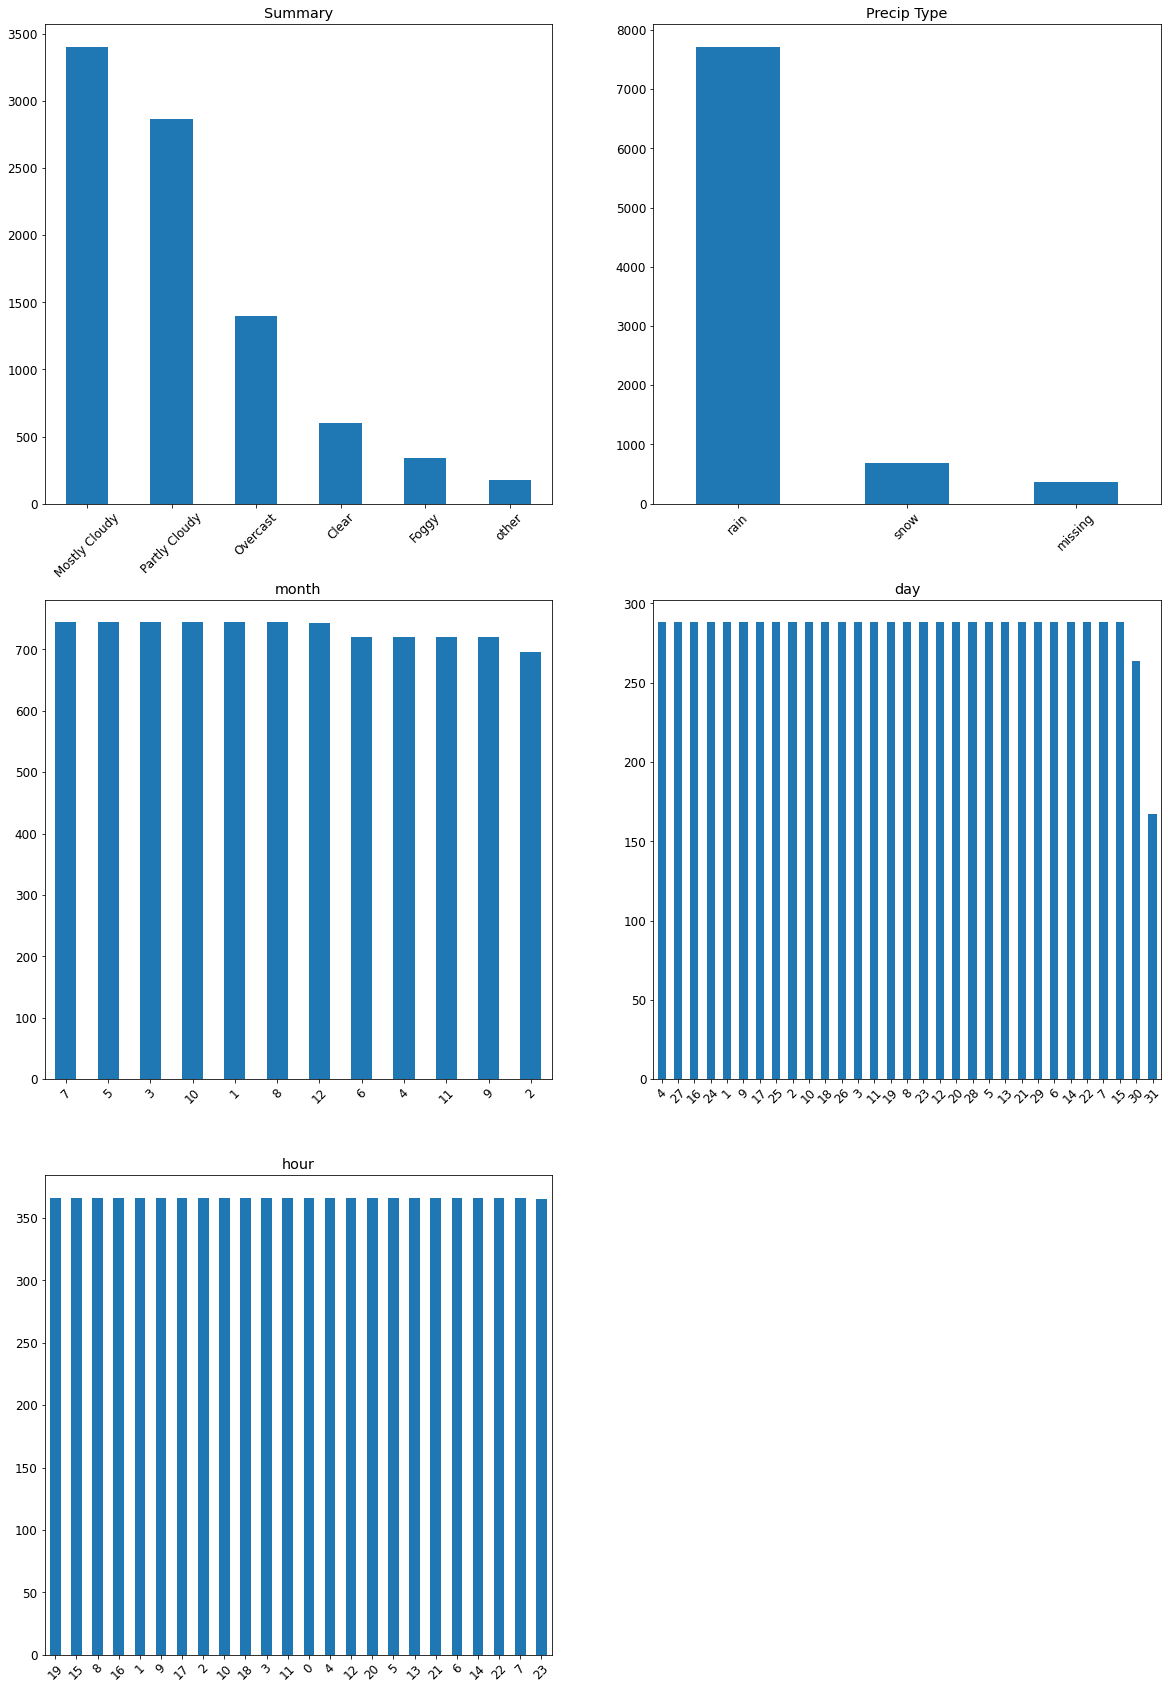

In [15]:
#define a figure to which we will add boxplots of each attribute.
plt.rcParams.update({'font.size': 12,'figure.figsize':(20,30)})

#use an index to identify the spot of the subplot
j=1
columns=df[categorical].columns.tolist()
for k in columns:   #for each numeric column in the dataframe
    plt.subplot(3,2,j) 
    df[k].value_counts().plot(kind='bar');
    plt.title(k)
    plt.xticks(rotation=45)
    j=j+1 #add 1 to go to the next subplot space

#show results
plt.show();

Will need to:
- Scale the features: year, month, day and hour.
- Create dummy columns for Summary and Precip Type

Next, lets create boxplots to see the categorical features vs temperature, the response variable.

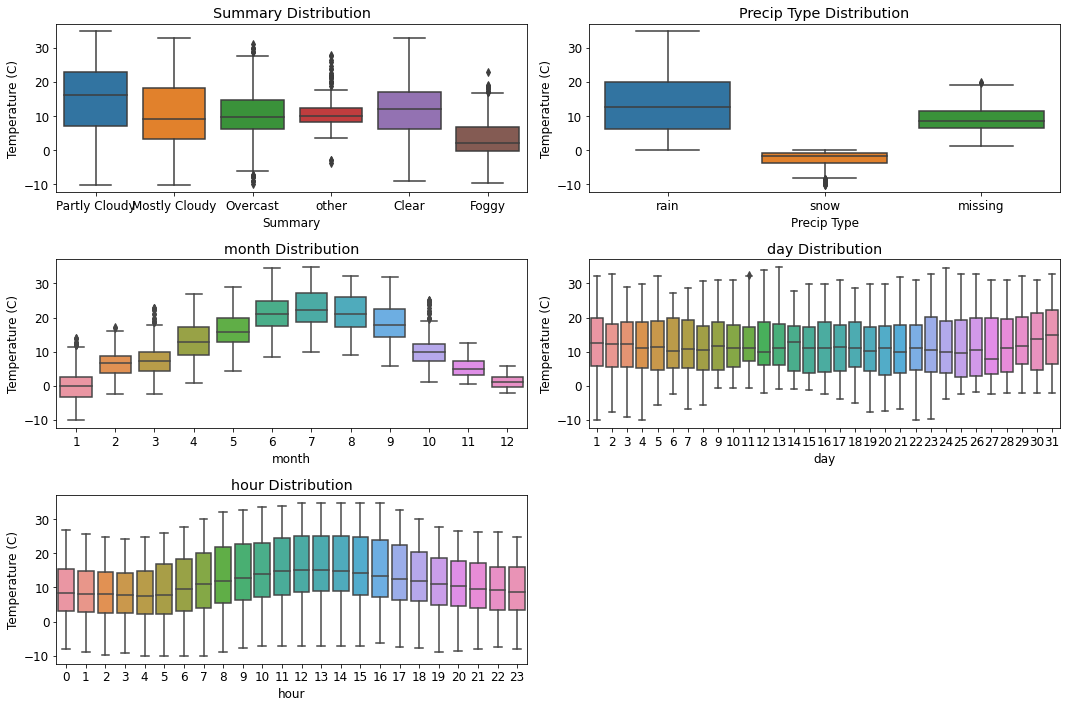

In [16]:
#define a figure to which we will add histogram of each attribute.
plt.figure(figsize=(15,10))

#use an index to identify the spot of the subplot
j = 1

# Columns
for k in categorical: #for each numeric column in the dataframe        
    plt.subplot(3,2,j)
    sns.boxplot(x=k, y = "Temperature (C)", data = df)
    plt.title(k + " Distribution");
    j = j + 1 #add 1 to go to the next subplot space

#show results
plt.tight_layout()
plt.show();

I can see that month, hour and precipitation type look to be potential good predictors for temperature. As it was expected, temperatures are higher during summer season, between June and August. <br>
Next I will scale the data and create dummy variables

In [17]:
# create list for feature to scale
to_scale = ['month', 'day', 'hour']

# initialize list for dummy columns
to_dummies = ['Summary','Precip Type']
categorical.remove('Summary')
categorical.remove('Precip Type')

# Getting dummy variables.
df = pd.get_dummies(df, columns = to_dummies)

# sanity check
df.head(2)

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),month,day,hour,Summary_Clear,Summary_Foggy,Summary_Mostly Cloudy,Summary_Overcast,Summary_Partly Cloudy,Summary_other,Precip Type_missing,Precip Type_rain,Precip Type_snow
87669,11.805556,11.805556,0.71,13.8943,170.0,16.1,1014.14,3,31,22,0,0,0,0,1,0,0,1,0
87670,11.805556,11.805556,0.71,10.9963,172.0,16.1,1013.95,3,31,23,0,0,0,0,1,0,0,1,0


### Analyzing numerical features

First step, create a correlation matrix to get some initial insights

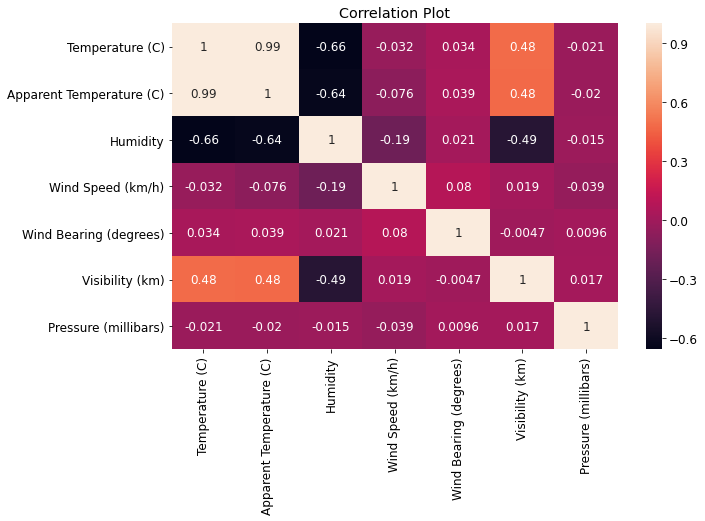

In [18]:
# initial correlation
cor = df[numeric].corr()
plt.figure(figsize=(10,6))
plt.title("Correlation Plot")
sns.heatmap(cor,annot=True)
plt.show()

There is almost perfect correlation between temperature and apparent temperature, and it would be a lurking variable, hence we can remove it. There seems to be some association between humidity and temperature.

In [19]:
# drop Precip Type
df = df.drop(['Apparent Temperature (C)'], axis=1)
numeric.remove('Apparent Temperature (C)')

In [20]:
# looking at summary statistics
df[numeric].describe()

,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
count,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000
mean,11.987381,0.760868,10.703967,185.445406,11.249147,1015.160243
std,9.029420,0.182269,6.149099,101.048647,4.550626,34.918068
min,-10.133333,0.230000,0.000000,0.000000,0.000000,0.000000
25%,4.788889,0.650000,6.359500,132.000000,8.404200,1012.900000
50%,11.088889,0.810000,10.062500,175.000000,10.352300,1017.080000
75%,18.800000,0.900000,13.894300,275.000000,15.649200,1019.980000
max,34.811111,1.000000,38.833200,359.000000,16.100000,1038.010000


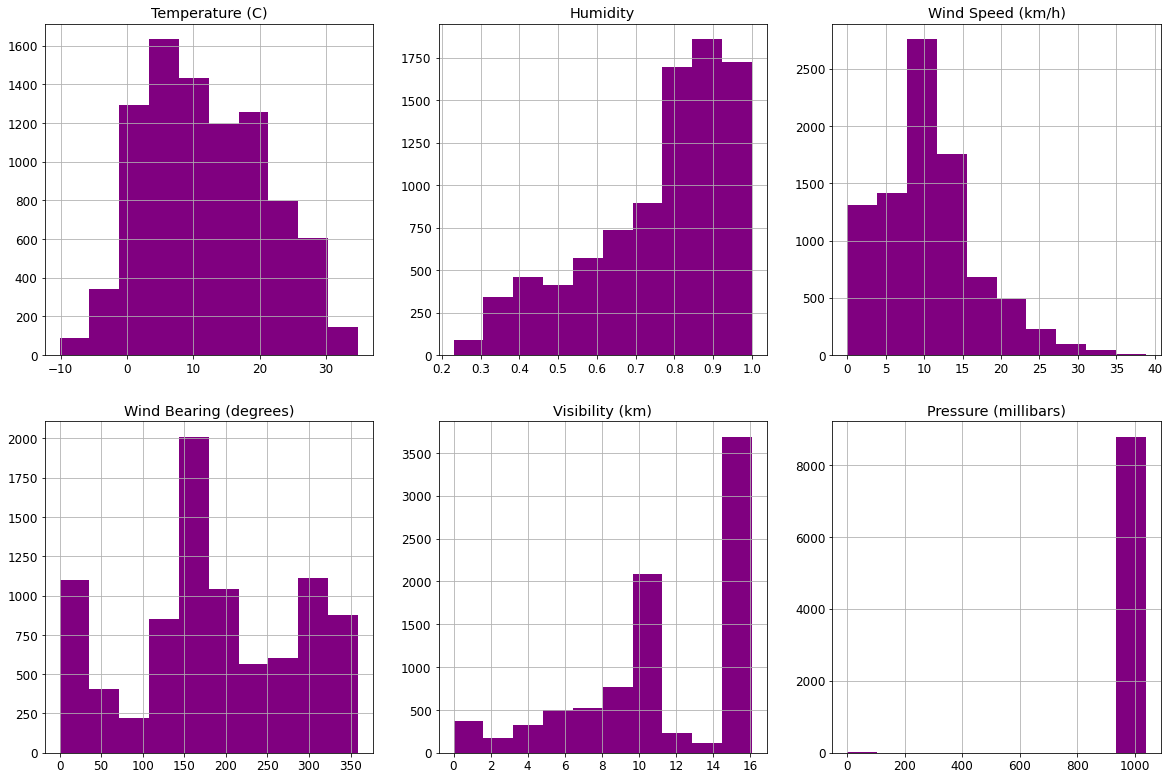

In [21]:
plt.rcParams.update({'font.size': 12,'figure.figsize':(20,50)})

#use an index to identify the spot of the subplot
j=1
columns=df[numeric].columns.tolist()
for k in columns:   #for each numeric column in the dataframe
    plt.subplot(7,3,j) 
    df[k].hist(color='purple');
    plt.title(k)
    j=j+1 #add 1 to go to the next subplot space

#show results
plt.show();

Air pressure below 200 millibar does not seem to make sense, lets see how many records are in the dataset.

In [22]:
df[df['Pressure (millibars)'] < 200].shape[0] / df.shape[0]

0.001138563133325743

It represents less than 1% of the data, lets exclude those records

In [23]:
df = df[df['Pressure (millibars)'] > 200]

#sanity check
df.shape

(8773, 18)

Need to scale the data

In [24]:
# append numeric elements
to_scale.extend(numeric)

# exclude response variable
to_scale.remove('Temperature (C)')

# sanity check
to_scale

['month',
 'day',
 'hour',
 'Humidity',
 'Wind Speed (km/h)',
 'Wind Bearing (degrees)',
 'Visibility (km)',
 'Pressure (millibars)']

In [25]:
# apply normalization to selected features
features = df[to_scale]
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
df[to_scale] = features

# sanity check
df.head(2)

,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),month,day,hour,Summary_Clear,Summary_Foggy,Summary_Mostly Cloudy,Summary_Overcast,Summary_Partly Cloudy,Summary_other,Precip Type_missing,Precip Type_rain,Precip Type_snow
87669,11.805556,0.623377,0.357794,0.473538,1.0,0.507022,0.181818,1.0,0.956522,0,0,0,0,1,0,0,1,0
87670,11.805556,0.623377,0.283167,0.479109,1.0,0.503098,0.181818,1.0,1.000000,0,0,0,0,1,0,0,1,0


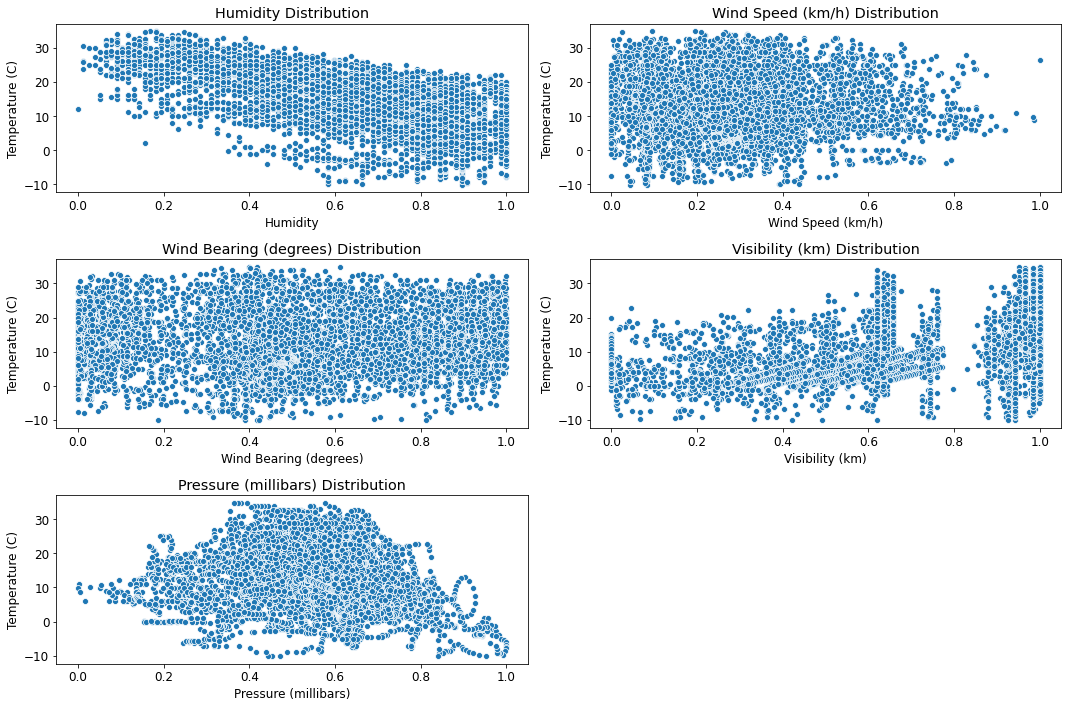

In [26]:
numeric.remove('Temperature (C)')
#define a figure to which we will add histogram of each attribute.
plt.figure(figsize=(15,10))

#use an index to identify the spot of the subplot
j = 1

# Columns
for k in numeric: #for each numeric column in the dataframe        
    plt.subplot(3,2,j)
    sns.scatterplot(x=k, y = "Temperature (C)", data = df)
    plt.title(k + " Distribution");
    j = j + 1 #add 1 to go to the next subplot space

#show results
plt.tight_layout()
plt.show();

We can see humidity looks like a potential predictor

In [27]:
df.columns

Index(['Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)',
       'month', 'day', 'hour', 'Summary_Clear', 'Summary_Foggy',
       'Summary_Mostly Cloudy', 'Summary_Overcast', 'Summary_Partly Cloudy',
       'Summary_other', 'Precip Type_missing', 'Precip Type_rain',
       'Precip Type_snow'],
      dtype='object')

## Numerical Prediction Modeling

Lets define the 3 selected categorical features plus humidity to be the predictors for all the regression models. I will have lists to store cross-validation metrics during training, and then another set of lists to collect the same metrics on the testing set.

In [28]:
df = df.rename(columns={'Temperature (C)': 'temperature', 'Humidity': 'humidity',
                       'Precip Type_rain': 'precip_type_rain', 'Precip Type_snow': 'precip_type_snow'})

# defining predictors
predictors = ['humidity', 'month', 'hour', 'precip_type_rain', 'precip_type_snow']

#model 1 with the first 3 features
X = df[predictors].copy()
y = df['temperature'].copy()

#creating train and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Metrics for training set
rmse_training = []
mae_training = []
r2_training = []

# Metrics for testing set
rmse_testing = []
mae_testing = []
r2_testing = []

### Linear Regression

In [29]:
# linear model to predict positive based on median_income
formula_string = "temperature ~ humidity + month + precip_type_rain + precip_type_snow"

model = sm.formula.ols(formula = formula_string, data = df)
model_fitted = model.fit()
print(model_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:            temperature   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     2907.
Date:                Sun, 18 Oct 2020   Prob (F-statistic):               0.00
Time:                        16:27:53   Log-Likelihood:                -28052.
No. Observations:                8773   AIC:                         5.611e+04
Df Residuals:                    8768   BIC:                         5.615e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           23.1177      0.395  

I can see the intercept and each of the features coefficient, which are all statistical significant (p-value < 0.05). Next I will use cross-validation to store the RMSE, MSE and R2 for the training set. Then make predictions on the testing set and collect the same 3 metrics.

In [30]:
# fit the model using 5-fold cross validation and get the metrics for the training set
lm = LinearRegression()
lm.fit(X_train, y_train)

# root mean square error 
lin_rmse = cross_val_score(lm, X_train, y_train, scoring = "neg_root_mean_squared_error", cv = 5).mean() * (-1)
rmse_training.append(lin_rmse)

# mean absolute error
lin_mae = cross_val_score(lm, X_train, y_train, scoring = "neg_mean_absolute_error", cv = 5).mean() * (-1)
mae_training.append(lin_mae)

# R2
r2 = cross_val_score(lm, X_train, y_train, scoring = "r2", cv = 5).mean() 
r2_training.append(r2)

In [31]:
# getting metrics for testing
# root mean square error 
predictions = lm.predict(X_test[predictors])
lin_mse = mean_squared_error(y_test, predictions)
lin_rmse = np.sqrt(lin_mse)
rmse_testing.append(lin_rmse)

# mean absolute error
lin_mae = mean_absolute_error(y_test, predictions)
mae_testing.append(lin_mae)

# R2
r2 = r2_score(y_test, predictions)
r2_testing.append(r2)

Text(0, 0.5, 'Residuals')

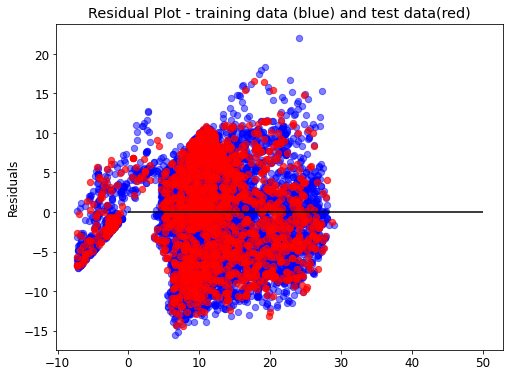

In [32]:
plt.figure(figsize=(8,6))
pred_train = lm.predict(X_train)
pred_test  = lm.predict(X_test)

plt.scatter(pred_train,pred_train - y_train, c = 'b',s=40,alpha=0.5)
plt.scatter(pred_test,pred_test - y_test, c = 'r',s=40,alpha=0.7)
plt.hlines(y = 0, xmin=0, xmax = 50)
plt.title('Residual Plot - training data (blue) and test data(red)')
plt.ylabel('Residuals')

The residuals don't look symmetrically distributed around the horizontal dashed line, then they don't exhibit a perfect linear
pattern.

### XGBoost

Although sklearn has a GradientBoostedClassifier, it is better to use a third-party implementation that uses extreme boosting, which tend to provide better results.

The parameters list in the third party XGBoost website were used to provide support for hyperparameters selection for grid-search execution.

- __max_depth:__ maximum tree depth, will test between 3 and 5.
- __eta (learning_rate):__ Step size shrinkage used in update to prevents overfitting. After each boosting step, I can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative. Considering the default parameter is 0.3 and it usually works well we will include it in our list. We will use [0.05, 0.1].
- __n_estimators:__ Number of rounds or boosted trees. We will tune using CV for a particular learning rate with the default 100 included. I will include the following [50, 100].

In [33]:
# Train XGBoost WITH gridsearch
parameters = {'max_depth': np.arange(3,5),
            'learning_rate': [0.05, 0.1],
             'n_estimators': [50, 100]
             }

xgb_reg = xgb.XGBRegressor()
grid = GridSearchCV(xgb_reg, parameters, scoring='neg_root_mean_squared_error', cv = 5) 
grid.fit(X_train, y_train)
model_est = grid.best_estimator_
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

In [34]:
# train the model with the best hyperparameters found by grid search
xgb_reg = xgb.XGBRegressor(
 max_depth = 4,
 learning_rate = 0.1,
 n_estimators = 100)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
# root mean square error 
lin_rmse = cross_val_score(xgb_reg, X_train, y_train, scoring = "neg_root_mean_squared_error", cv = 5).mean() * (-1)
rmse_training.append(lin_rmse)

# mean absolute error
lin_mae = cross_val_score(xgb_reg, X_train, y_train, scoring = "neg_mean_absolute_error", cv = 5).mean() * (-1)
mae_training.append(lin_mae)

# R2
r2 = cross_val_score(xgb_reg, X_train, y_train, scoring = "r2", cv = 5).mean() 
r2_training.append(r2)

In [36]:
# getting metrics for testing
# root mean square error 
predictions = xgb_reg.predict(X_test[predictors])
lin_mse = mean_squared_error(y_test, predictions)
lin_rmse = np.sqrt(lin_mse)
rmse_testing.append(lin_rmse)

# mean absolute error
lin_mae = mean_absolute_error(y_test, predictions)
mae_testing.append(lin_mae)

# R2
r2 = r2_score(y_test, predictions)
r2_testing.append(r2)

### Decision Tree

In this section I create a decision tree and we follow an empirical process as we chose the best hyper-parameters using a grid search. I will look for the best combination among the following parameters:

- __max_depth:__ The maximum depth of the tree. To stop the nodes from expanding until all leaves are pure we specify a range between 3 and 5.
- __min_samples_split:__ The minimum number of samples required to split an internal node, I specify 2 and 3 for this parameter.

In [37]:
# Train tree WITH gridsearch
parameters = {'min_samples_split':[2,3], 
              'max_depth':np.arange(3,5)}

tree_reg = DecisionTreeRegressor()
grid = GridSearchCV(tree_reg, parameters, scoring='neg_root_mean_squared_error', cv=5)
grid.fit(X_train, y_train)
model_est = grid.best_estimator_
model_params = grid.best_params_
grid.best_params_

{'max_depth': 4, 'min_samples_split': 2}

In [38]:
tree_reg = DecisionTreeRegressor( 
    min_samples_split = 2,
    max_depth = 4)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4)

In [39]:
# root mean square error 
lin_rmse = cross_val_score(tree_reg, X_train, y_train, scoring = "neg_root_mean_squared_error", cv = 5).mean() * (-1)
rmse_training.append(lin_rmse)

# mean absolute error
lin_mae = cross_val_score(tree_reg, X_train, y_train, scoring = "neg_mean_absolute_error", cv = 5).mean() * (-1)
mae_training.append(lin_mae)

# R2
r2 = cross_val_score(tree_reg, X_train, y_train, scoring = "r2", cv = 5).mean() 
r2_training.append(r2)

In [40]:
# getting metrics for testing
# root mean square error 
predictions = tree_reg.predict(X_test[predictors])
lin_mse = mean_squared_error(y_test, predictions)
lin_rmse = np.sqrt(lin_mse)
rmse_testing.append(lin_rmse)

# mean absolute error
lin_mae = mean_absolute_error(y_test, predictions)
mae_testing.append(lin_mae)

# R2
r2 = r2_score(y_test, predictions)
r2_testing.append(r2)

### SVM

- __kernel:__ Apply kernels to transform the data to a higher dimension, in this case will use linear and poly.

- __degree:__ Degree is a parameter used when kernel is set to ‘poly’. It’s the degree of the polynomial used to find the hyperplane to split the data. In this case we will try 2 values: 2 and 3.

Regularization parameters:

- __C:__ The strength of the regularization is inversely proportional to C. Must be strictly positive. Large value of 'c' means you will get more intricate decision curves trying to fit in all the points. Figuring out how much you want to have a smooth decision boundary vs one that gets things correct is part of artistry of machine learning. So try different values of c for your dataset to get the perfectly balanced curve and avoid over fitting. For our first parameter C: so we choose to values incrementally. First we start with one small and the other large to understand whether or not it works best with smaller values or larger values. When C=1: the SVM boundaries will be wider allowing a large amount of margin violations but will probably generalize better.

- __gamma:__ Increasing gamma makes the bell-shaped curve narrower. As a result, each instance’s range of influence is smaller: the decision boundary ends up being more irregular, wiggling around individual instances. Conversely, a small gamma value makes the bell-shaped curve wider: instances have a larger range of influence, and the decision boundary ends up smoother. That's why it is essential to choose the appropriate value for gamma. I choose to keep the default, which is 1.

In [41]:
# perform gridsearch to get lowest mean square error score
param_grid = {'degree':[2,3], 'kernel': ['poly','linear']}
svm = GridSearchCV(SVR(), param_grid, scoring = 'neg_root_mean_squared_error') 
svm.fit(X_train,y_train)
print(svm.best_params_)

{'degree': 3, 'kernel': 'poly'}


In [42]:
# Fit SVM model with best hyperparameters
svm = make_pipeline(PolynomialFeatures(degree=3), SVR(kernel = 'poly'))
svm.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('svr', SVR(kernel='poly'))])

In [43]:
# root mean square error 
lin_rmse = cross_val_score(svm, X_train, y_train, scoring = "neg_root_mean_squared_error", cv = 5).mean() * (-1)
rmse_training.append(lin_rmse)

# mean absolute error
lin_mae = cross_val_score(svm, X_train, y_train, scoring = "neg_mean_absolute_error", cv = 5).mean() * (-1)
mae_training.append(lin_mae)

# R2
r2 = cross_val_score(svm, X_train, y_train, scoring = "r2", cv = 5).mean() 
r2_training.append(r2)

In [44]:
# getting metrics for testing
# root mean square error 
predictions = svm.predict(X_test[predictors])
lin_mse = mean_squared_error(y_test, predictions)
lin_rmse = np.sqrt(lin_mse)
rmse_testing.append(lin_rmse)

# mean absolute error
lin_mae = mean_absolute_error(y_test, predictions)
mae_testing.append(lin_mae)

# R2
r2 = r2_score(y_test, predictions)
r2_testing.append(r2)

## Model Selection

Lets see the scoring metrics and compare the 3 models.

In [45]:
print("\t \t The Model Metric Matrix for the training set")
# Cross validation.
metrics_training = pd.DataFrame()
metrics_training['Model #'] = ['Linear Regression', 'XGBoost', 'Desicion Tree','SVM']
metrics_training['RMSE'] = rmse_training
metrics_training['MAE'] = mae_training
metrics_training['R2'] = r2_training
metrics_training

	 	 The Model Metric Matrix for the training set


,Model #,RMSE,MAE,R2
0,Linear Regression,5.920758,4.960952,0.570044
1,XGBoost,2.692430,2.072638,0.911158
2,Desicion Tree,4.020430,3.100655,0.801905
3,SVM,3.305151,2.595182,0.866111


XGBoost outperforms all the other 3 models in all metrics, and despite it is not an easy model to interpret it is the one that provides the most accurate results in terms of RMSE, MAE (in these 2 metrics shows the lowest, hence better results) and R2, where the larger the value of R2 then the more accurate is.

In [46]:
print("\t \t The Model Metric Matrix for the testing set")
metrics_testing = pd.DataFrame()
metrics_testing['Model #'] = ['Linear Regression', 'XGBoost', 'Desicion Tree','SVM']
metrics_testing['RMSE'] = rmse_testing
metrics_testing['MAE'] = mae_testing
metrics_testing['R2'] = r2_testing
metrics_testing

	 	 The Model Metric Matrix for the testing set


,Model #,RMSE,MAE,R2
0,Linear Regression,5.903879,4.966802,0.571629
1,XGBoost,2.756625,2.134381,0.906610
2,Desicion Tree,4.069410,3.145773,0.796479
3,SVM,3.252236,2.568290,0.870010


In the testing set there is a similar pattern for all 4 type of models, with XGBoost at the top. This consistency allows to choose it as the winner since it shows the best performance in all our metrics and shows no signs of overfiting.

# Part B: Yes/No Prediction

This [dataset](https://www.kaggle.com/mathchi/diabetes-data-set) is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes.

Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

## Data Dictionary
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes.
- Pregnancies: Number of times pregnant
- Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- BloodPressure: Diastolic blood pressure (mm Hg)
- SkinThickness: Triceps skin fold thickness (mm)
- Insulin: 2-Hour serum insulin (mu U/ml)
- BMI: Body mass index (weight in kg/(height in m)^2)
- DiabetesPedigreeFunction: Diabetes pedigree function
- Age: Age (years)
- Outcome: Class variable (0 or 1)

## EDA

In [47]:
# importing data and loading into a dataframe
df = pd.read_csv('https://raw.githubusercontent.com/gitjuli/AutoML/master/Data/diabetes.csv')
df.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


Next, I will check the dimension, data types and null values.

In [48]:
df.shape

(768, 9)

In [49]:
# checking data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [50]:
null_count = df.isnull().sum()

# get percent of missing data
missing = df.isnull().mean() * 100

#creating a dictionary with the count of null and negative values
d = {'# Missing':null_count,'% of Total':missing}
pd.DataFrame(d)

,# Missing,% of Total
Pregnancies,0,0.0
Glucose,0,0.0
BloodPressure,0,0.0
SkinThickness,0,0.0
Insulin,0,0.0
BMI,0,0.0
DiabetesPedigreeFunction,0,0.0
Age,0,0.0
Outcome,0,0.0


There are no null values. Lets see the response distribution, and for simplicity I will rename the response to 'has_diabetes' and assign 'yes' or 'no'.

In [51]:
df = df.rename(columns={'Outcome': 'has_diabetes'})
df.has_diabetes.replace([0, 1], ['no', 'yes'], inplace = True)
df.has_diabetes = df.has_diabetes.astype(str)

no     500
yes    268
Name: has_diabetes, dtype: int64
percentage of patients without diabetes:  65.10416666666666
percentage of patients with diabetes:  34.89583333333333


Text(0.5, 1.0, 'Patients distribution')

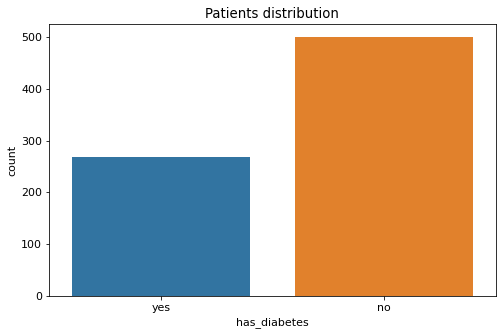

In [52]:
plt.rcParams.update({'font.size': 11,'figure.figsize':(8,5)})

#print value counts
print(df.has_diabetes.value_counts())

#get separate counts for each response value to see %
count_no_diabetes = len(df[df['has_diabetes']=='no'])
count_diabetes = len(df[df['has_diabetes']=='yes'])

pct_of_no_diabetes = count_no_diabetes/(count_no_diabetes+count_diabetes)
print("percentage of patients without diabetes: ", pct_of_no_diabetes*100)
pct_of_diabetes = count_diabetes/(count_no_diabetes+count_diabetes)
print("percentage of patients with diabetes: ", pct_of_diabetes*100)
sns.countplot(x = 'has_diabetes', data = df).set_title("Patients distribution")

We have an imbalance response variable. Below lets look at the connection between each of the explanatory variables and the response.

In [53]:
df.groupby('has_diabetes').mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
has_diabetes,,,,,,,,
no,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,31.190000
yes,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


We can see that on average, people that have diabetes have higher stats in all of the indicators. <br>
Now we will look at the correlations between numeric explanatory variables to detect initial collinearity.

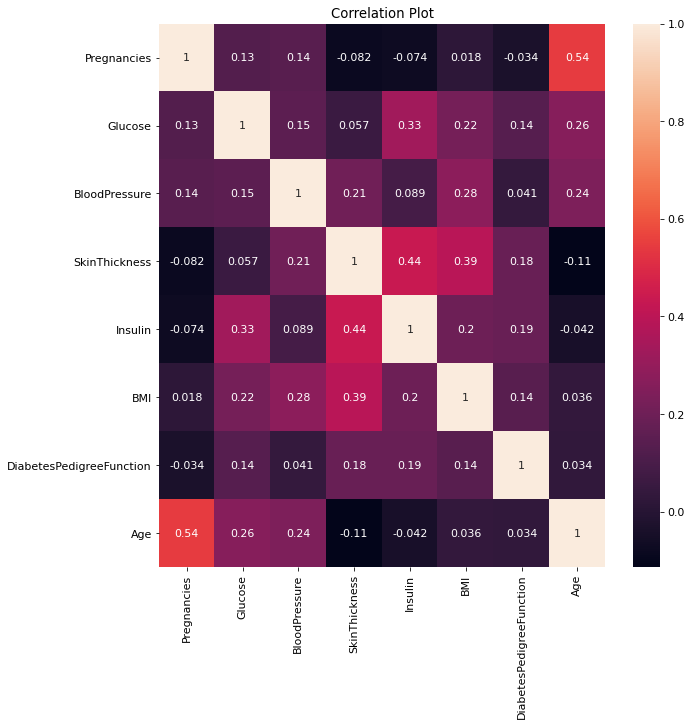

In [54]:
# initial correlation
explanatory = df.loc[:, df.columns != 'has_diabetes'].columns
cor = df[explanatory].corr()
plt.figure(figsize=(10,10))
plt.title("Correlation Plot")
sns.heatmap(cor,annot=True)
plt.show()

There seems to be some collinearity. Next lets see the distributions closer and the association with the response.

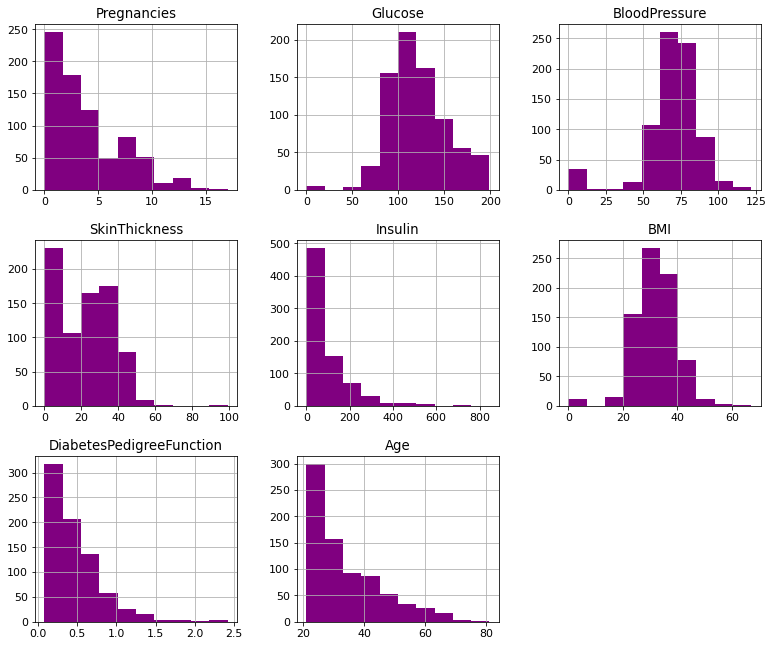

In [55]:
# looking at the explanatory distributions
df[explanatory].hist(figsize=(13, 11), color='purple');
plt.show();

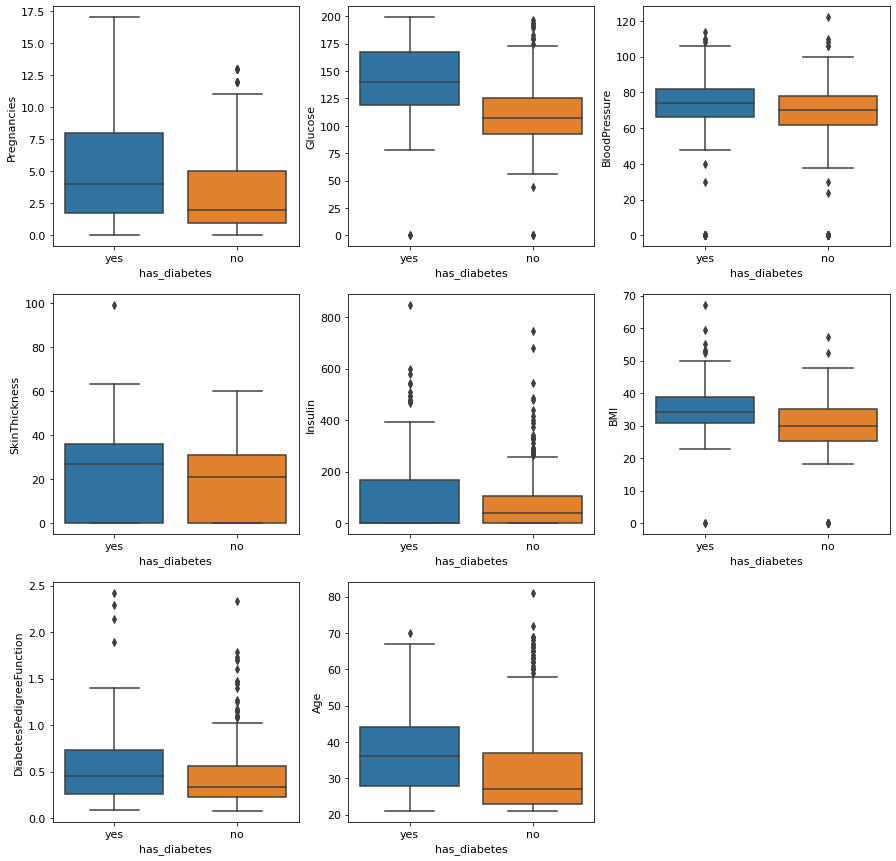

In [56]:
#define a figure to which we will add boxplots of each attribute.
plt.figure(figsize=(15,15))

#use an index to identify the spot of the subplot
j=1
columns=df[explanatory].columns.tolist()
for k in columns:   #for each numeric column in the dataframe
    plt.subplot(3,3,j) 
    sns.boxplot(x="has_diabetes", y=k,data=df)
    j=j+1 #add 1 to go to the next subplot space

#show results
plt.show();

There are several predictors that look promising, like Insulin, Glucose and Age.
<br>
Let's look at outliers and some data points that are not consistent for patients that are alive, like having BloodPressure of zero.

In [57]:
df[df.BloodPressure == 0].shape

(35, 9)

In [58]:
df = df[df.BloodPressure != 0]
df.shape

(733, 9)

In [59]:
# converting back to integer
df.has_diabetes.replace(["no", "yes"], ['0', '1'], inplace = True)
df.has_diabetes = df.has_diabetes.astype(int)

Considering the imbalance class in the response we need to find a way to make the 2 outcomes somewhat even. With our training data created, I’ll up-sample the no-deny using the SMOTE algorithm(Synthetic Minority Oversampling Technique). At a high level, SMOTE:
- Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
- Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

In [60]:
# Splitting into predictors and response.
X = df.loc[:, df.columns != 'has_diabetes']
y = df.loc[:, 'has_diabetes']

# Balancing
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Columns
columns = X_train.columns

# Split and balance
os_data_X, os_data_y = os.fit_sample(X_train, y_train)

# Changing 
os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y = pd.DataFrame(data=os_data_y,columns=['has_diabetes'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['has_diabetes']==0]))
print("Number of subscription",len(os_data_y[os_data_y['has_diabetes']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['has_diabetes']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['has_diabetes']==1])/len(os_data_X))

length of oversampled data is  672
Number of no subscription in oversampled data 336
Number of subscription 336
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [61]:
# Making a copy of the last original data frame.
df = os_data_X.copy()
df['has_diabetes'] = os_data_y

Now that we have a balanced dataset, lets use univariate feature selection with chi-squared to obtain a ranking and make a more educated decision on the best predictors.

In [62]:
X = df[explanatory]
y = df.has_diabetes

In [63]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier

# find best scored 5 features
select_feature = SelectKBest(chi2, k=4).fit(X,y)

# Created a dictionary.
dic = {}
for score, name in zip(select_feature.scores_,X.columns):
    dic[name] = score
    
# Sorting the dictionary.
dic = {k: v for k, v in sorted(dic.items(), key=lambda item: item[1], reverse=True)}
dic

{'Insulin': 2333.2603336346456,
 'Glucose': 1386.8073659078552,
 'Age': 153.67915280938212,
 'SkinThickness': 85.64870931537598,
 'Pregnancies': 85.55734112490869,
 'BMI': 71.60999087608498,
 'BloodPressure': 22.698797172735915,
 'DiabetesPedigreeFunction': 5.490747080071883}

The top 5 predictors will include Age and Pregnancies, but as I saw some collinearity between these 2 features. In addition, Insulin had some collinearity with SkinThickness and Glucose, so lets exclude Insulin too.

## Yes/No Prediction Modeling

In this section we will make use of the feature selection and EDA work to create 3 logistic regression models.

In [64]:
# defining predictors
predictors = ['Glucose', 'Age', 'SkinThickness']

### Logistic Regression

In [82]:
#model 1 with EDA features
X = df[predictors]
y = df['has_diabetes']

#creating train and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#Fitting Logistic Regression to the Training set with the first set of predictors.
classifier1 = LogisticRegression()
classifier1.fit(X_train, y_train)

#examine the model coefficients for the explanatory variables
print('coefficients')
print(predictors)
print(classifier1.coef_)

# Cross validation.
accuracy_training = []
auc_training = []

# testing
accuracy_testing = []
auc_testing = []

accuracy = cross_val_score(classifier1, X_train, y_train, scoring = "accuracy", cv = 5)
auc = cross_val_score(classifier1, X_train, y_train, scoring = "roc_auc", cv = 5)

accuracy_training.append(accuracy.mean())
auc_training.append(auc.mean())

coefficients
['Glucose', 'Age', 'SkinThickness']
[[0.03884132 0.03821873 0.01129497]]


From the above we see that:

- A decrease in insuline levels is associated with an increased likelihood of having diabetes.
- An increase in glocose, age and SkinThickness is associated with an increased likelihood of having diabetes.

In [83]:
# make predictions and store metrics
import sklearn.metrics as metrics
y_pred1 = classifier1.predict(X_test)
auc_testing.append(np.mean(metrics.roc_auc_score(y_test,y_pred1)))
accuracy_testing.append(metrics.accuracy_score(y_test,y_pred1))

ROC for Logistic Regression

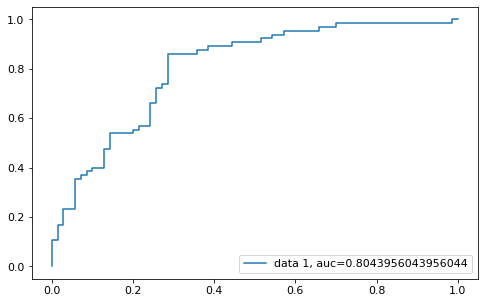

In [84]:
y_pred_proba = classifier1.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Multinomial Logistic Regression

In [85]:
# Train multinomial logistic regression model
classifier2 = LogisticRegression(multi_class='multinomial', solver='newton-cg')
classifier2.fit(X_train, y_train)

accuracy = cross_val_score(classifier2, X_train, y_train, scoring = "accuracy", cv = 5)
auc = cross_val_score(classifier2, X_train, y_train, scoring = "roc_auc", cv = 5)

accuracy_training.append(accuracy.mean())
auc_training.append(auc.mean())

y_pred2 = classifier2.predict(X_test)
auc_testing.append(np.mean(metrics.roc_auc_score(y_test,y_pred2)))
accuracy_testing.append(metrics.accuracy_score(y_test,y_pred2))

ROC for Multiclass Logistic Regression

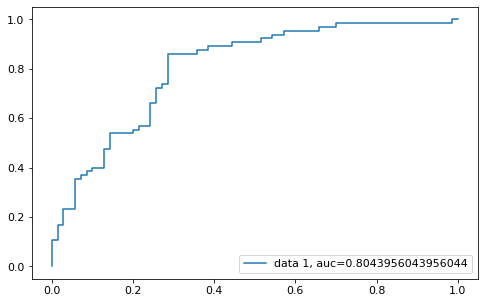

In [86]:
y_pred_proba = classifier2.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Oldinal Logistic Regression
I was not able to find an implementation within Python.

In [87]:
from mord import LogisticAT
classifier3 = LogisticAT(alpha=0)
classifier3.fit(X_train, y_train)

accuracy = cross_val_score(classifier3, X_train, y_train, scoring = "accuracy", cv = 5)
auc = cross_val_score(classifier3, X_train, y_train, scoring = "roc_auc", cv = 5)

accuracy_training.append(accuracy.mean())
auc_training.append(auc.mean())

y_pred3 = classifier2.predict(X_test)
auc_testing.append(np.mean(metrics.roc_auc_score(y_test,y_pred3)))
accuracy_testing.append(metrics.accuracy_score(y_test,y_pred3))

## Model Selection

Lets see the scoring metrics and compare the 3 models.

In [88]:
print("\t \t The Model Metric Matrix for the training set")
# Cross validation.
metrics_training = pd.DataFrame()
metrics_training['Model #'] = ['Logistic Regression', 'Multinomial LR', 'Ordinal LR']
metrics_training['Accuracy'] = accuracy_training
metrics_training['AUC'] = auc_training
metrics_training

	 	 The Model Metric Matrix for the training set


,Model #,Accuracy,AUC
0,Logistic Regression,0.718865,0.816063
1,Multinomial LR,0.718865,0.816063
2,Ordinal LR,0.722568,0.814577


In [89]:
print("\t \t The Model Metric Matrix for the testing set")
metrics_testing = pd.DataFrame()
metrics_testing['Model #'] = ['Logistic Regression', 'Multinomial LR', 'Ordinal LR']
metrics_testing['Accuracy'] = accuracy_testing
metrics_testing['AUC'] = auc_testing
metrics_testing

	 	 The Model Metric Matrix for the testing set


,Model #,Accuracy,AUC
0,Logistic Regression,0.711111,0.709341
1,Multinomial LR,0.711111,0.709341
2,Ordinal LR,0.711111,0.709341


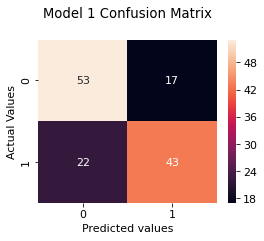

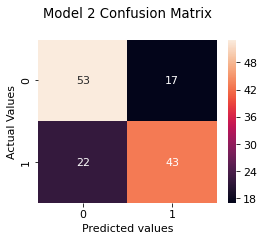

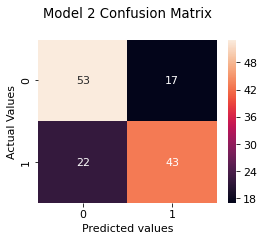

In [90]:
######  Confusion Matrix For Model 1   #####
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(4, 3))
cm_2 = confusion_matrix(y_test, y_pred1)
sns.heatmap(cm_2,annot=True,fmt="d")
plt.title("Model 1 Confusion Matrix\n")
plt.ylabel('Actual Values')
plt.xlabel('Predicted values')
plt.show();

##### Confusion Matrix for Model 2 ####
plt.figure(figsize=(4, 3))
cm_2 = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm_2,annot=True,fmt="d")
plt.title("Model 2 Confusion Matrix\n")
plt.ylabel('Actual Values')
plt.xlabel('Predicted values')
plt.show();

##### Confusion Matrix for Model 3 ####
plt.figure(figsize=(4, 3))
cm_2 = confusion_matrix(y_test, y_pred3)
sns.heatmap(cm_2,annot=True,fmt="d")
plt.title("Model 2 Confusion Matrix\n")
plt.ylabel('Actual Values')
plt.xlabel('Predicted values')
plt.show();

The models show equivalent metrics. I choose module 1, Logistic Regression, since it is the easiest to interpret.

# Part C: Clustering
## Data Dictionary (same as Part B)

For this section I will implement K-means algorithm on the dataset used in Part B, regarding patients with diabetes. This is a partition-based clustering to split the data into partitions based on the distances between the data points.

## Cluster Modeling, K-means

Before starting with the models I will exclude the original response variable.

In [73]:
df.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,has_diabetes
0,3,84,68,30,106,31.9,0.591,25,0
1,1,189,60,23,846,30.1,0.398,59,1


In [74]:
y_original = df.pop("has_diabetes")
df.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,3,84,68,30,106,31.9,0.591,25
1,1,189,60,23,846,30.1,0.398,59


Need to scale all the features before performing clustering.

In [75]:
to_scale = df.columns

In [76]:
# apply normalization to selected features
features = df[to_scale]
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
df[to_scale] = features

# sanity check
df.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.176471,0.422111,0.448980,0.303030,0.125296,0.537037,0.219044,0.066667
1,0.058824,0.949749,0.367347,0.232323,1.000000,0.506734,0.136635,0.633333


Understanding Inertia as the sum of squared distances between each data point in a cluster and the cluster's centroid, the code below implements a K-means clustering algorithm using a range values of K (from 2 to 12) and will fit the data and get the resulting inertia, which is stored in the list 'inertias'. Then a plot is created to show for each K the corresponding inertia value.

Text(0, 0.5, 'Inertia')

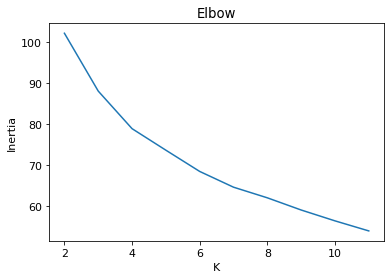

In [77]:
inertias = []
sizes = range(2, 12)
for k in sizes:
    k2 = KMeans(random_state=42, n_clusters=k)
    k2.fit(df)
    inertias.append(k2.inertia_)
fig, ax = plt.subplots(figsize=(6, 4))
pd.Series(inertias, index=sizes).plot(ax=ax)
plt.title("Elbow")
ax.set_xlabel("K")
ax.set_ylabel("Inertia")

Here I see that the curve bends at K= 6 (which is potentially a good choice for the number of clusters). In this case, the curve is smooth, but after K = 8 there is not significant improvement. To have a better sense of the best value for K I will create the Silhouette Coefficient, which is a value between -1 and 1( where and the higher the score the better).
Below is the the Silhouette diagram, which shows every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. It is created from K= 2 to K = 6.

C:\Users\julir\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


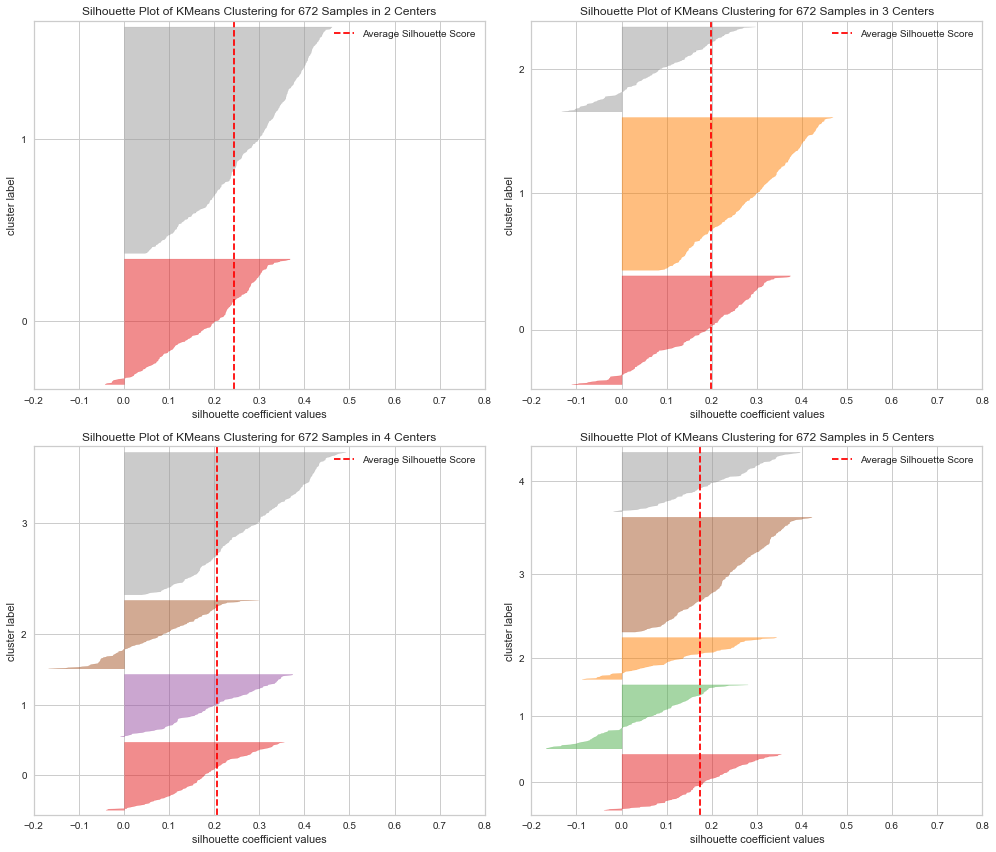

In [78]:
from yellowbrick.cluster.silhouette import (
    SilhouetteVisualizer,
)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.reshape(4)
for i, k in enumerate(range(2, 6)):
    ax = axes[i]
    sil = SilhouetteVisualizer(
        KMeans(n_clusters = k, random_state = 42 ),
        ax=ax,
    )
    sil.fit(df)
    sil.finalize()
    ax.set_xlim(-0.2, 0.8)
plt.tight_layout()

The vertical dotted red line in this plot above is the average silhouette score. One way to interpret it is to make sure that each cluster boundary rises above the average, and the cluster scores look decent. What we can infer from this graph is that all clusters centers rise above the average, and in this case I see it for all the 4 graphs.

Considering that for 2 clusters it shows a higher silhouette coefficient value (around 0.25), then 2 is the best number of clusters. Below we look closer at the silhouette score for each K in a line graph.

C:\Users\julir\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\julir\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\julir\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


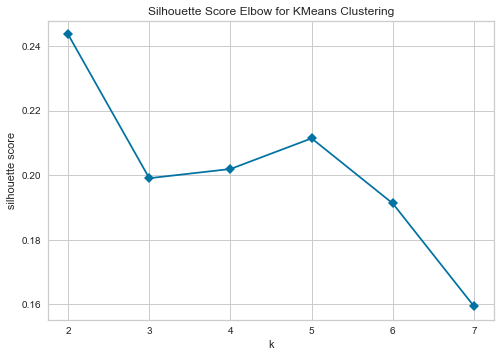

In [79]:
from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2,8),metric='silhouette',locate_elbow= True,timings=False)
visualizer.fit(df)
visualizer.poof()
plt.show();

K-means clustering with 2 groups and adding the corresponding label as new column in the dataframe.

In [80]:
kmeans_model = KMeans(n_clusters = 2 , random_state = 42)
k_fit = kmeans_model.fit(df)
predictions = k_fit.labels_
predictions[:5]

array([1, 0, 1, 0, 1])

In [81]:
df['cluster_label'] = predictions # this is for the normalized dataset to be passed on to the model
df.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,cluster_label
0,0.176471,0.422111,0.448980,0.303030,0.125296,0.537037,0.219044,0.066667,1
1,0.058824,0.949749,0.367347,0.232323,1.000000,0.506734,0.136635,0.633333,0


To understand better the 2 clusters I will look at some summary statistics.

In [82]:
df.cluster_label.value_counts()

1    432
0    240
Name: cluster_label, dtype: int64

In [83]:
df.groupby('cluster_label').mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
cluster_label,,,,,,,,
0,0.434559,0.682161,0.536692,0.192172,0.093587,0.552196,0.166376,0.416806
1,0.131400,0.605179,0.463790,0.247405,0.114490,0.559073,0.181021,0.105633


It seems that the cluster 1 corresponds to groups of people with diabetes, as it has higher number for regnancies, glucose, blood pressure, age and lower levels of insulin. Hence, the cluster labels seems to indicate weather a patient has diabetes or not. <br>
Next let's add the actual labels and compare both outcomes

In [84]:
df['has_diabetes'] = y_original

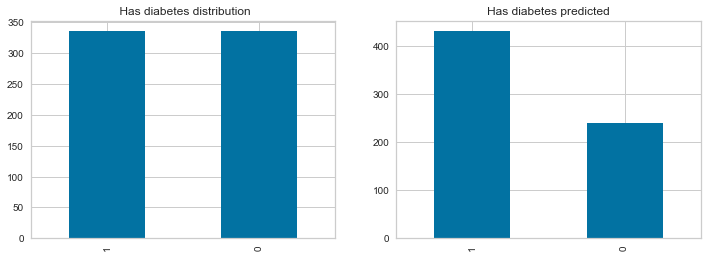

In [85]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
df['has_diabetes'].value_counts().plot(kind='bar');
plt.title(' Has diabetes distribution')
plt.subplot(1,2,2)
df['cluster_label'].value_counts().plot(kind='bar');
plt.title('Has diabetes predicted')
plt.show();

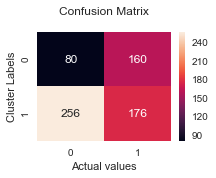

In [86]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix 
plt.figure(figsize=(3, 2))
conf = confusion_matrix(df.cluster_label, df.has_diabetes)
sns.heatmap(conf, annot=True , fmt="d")
plt.title("Confusion Matrix\n")
plt.ylabel('Cluster Labels')
plt.xlabel('Actual values')
plt.show();

The created clusters labels seem to miss-classify more patients that actually had diabetes as with no diabetes, meaning it has a higher number of false negatives (176) than false positives (80)